# Explanatory Anomaly Detection on Nuscenes data

This system demos the reasonableness monitoring system and anomaly detection through explanations on the Nuscenes dataset.  This code assumes that the database is available at `../data/`, but this can be changed to the directory where the dataset is located.  

This is processing on the mini version of the full dataset.  The full dataset processing will soon follow.  

In [3]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import pprint as pp
from nuscenes.utils.data_classes import *

# TODO: this should be changed somewhere 
data_root = '/Users/leilani/Dropbox (MIT)/car-can-explain/data/'
nuscenes_root = data_root+'nuscenes-data/'
data_name = 'v1.0-mini'

nusc = NuScenes(version=data_name, dataroot=nuscenes_root+data_name, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.7 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


# Testing that the driver code runs.

The driver currently runs the uber example and searches through a commonsense knowledge base (ConceptNet) with verbose messages .  

In [44]:
!python3 driver.py -v

INFO: Verbose output.
INFO: Explaining behavior in the vehicle domain

DEBUG: commonsense/relations.csv is parsed as a csv file
DEBUG:    Relation URI  ...                       Examples
0  ------------  ...                       --------
1  /r/RelatedTo  ...              learn ↔ erudition
2     /r/FormOf  ...                  slept → sleep
3        /r/IsA  ...  car → vehicle; Chicago → city
4     /r/PartOf  ...                gearshift → car

[5 rows x 3 columns]
DEBUG: commonsense/anchors.csv is parsed as a csv file
DEBUG:    Relation URI  ...                       Examples
0  ------------  ...                       --------
1  /r/RelatedTo  ...              learn ↔ erudition
2     /r/FormOf  ...                  slept → sleep
3        /r/IsA  ...  car → vehicle; Chicago → city
4     /r/PartOf  ...                gearshift → car

[5 rows x 3 columns]
SHOULDN'T HAVE
DEBUG: searching for an anchor point for unknown_object
DEBUG: anchor point object is partof the concept phrase: unknown

## A Gentle Introduction to nuScenes (from tutorial)

Here are the top-down introduction of our database. This section is an elaboration of `schema.md`. The dataset comprises of elemental building blocks that are the following:

1. `scene` - 20 second snippet of a car's journey.
2. `sample` - An annotated snapshot of a scene at a particular timestamp.
3. `sample_data` - Data collected from a particular sensor.
4. `sample_annotation` - An annotated instance of an object within our interest.
5. `instance` - Enumeration of all object instance we observed.
6. `category` - Taxonomy of object categories (e.g. vehicle, human). 
7. `attribute` - Property of an instance that can change while the category remains the same.
8. `visibility` - Fraction of pixels visible in all the images collected from 6 different cameras.. 
9. `sensor` - A specific sensor type.
10. `calibrated sensor` - Definition of a particular sensor as calibrated on a particular vehicle.
11. `ego_pose` - Ego vehicle poses at a particular timestamp.
12. `log` - Log information from which the data was extracted.
13. `map` - Map data that is stored as binary semantic masks from a top-down view.

### 1. `scene`

nuScenes is a large scale database that features annotated samples across ***1000 scenes*** of approximately 20 seconds each. Let's take a look at the scenes that we have in the loaded database.

In [2]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

Let's look at a scene metadata

In [4]:
first_scene = nusc.scene[0]
fourth_scene = nusc.scene[4]
first_scene

def get_description(scene):
    """
    Returns a list of the descriptions of a particular scene
    Underscores make it easier to query the commonsense knowledge base
    """
    text_description = scene['description']
    descriptions = text_description.split(',')
    description_list = []
    for label in descriptions:
        # for conceptNet debugging
        description_list.append(label.strip().replace(' ', '_').lower())
    return description_list

print(get_description(first_scene))
print(get_description(fourth_scene))

['parked_truck', 'construction', 'intersection', 'turn_left', 'following_a_van']
['arrive_at_busy_intersection', 'bus', 'wait_at_intersection', 'bicycle', 'peds']


### Nuscenes Analysis and Testing

In [43]:
import datetime
NORMALIZE = 1000000.0
import commonsense.conceptnet as kb
import monitor.reasonableness_monitor as monitor

anchors = ['animal', 'object', 'place', 'plant']
relations = ['AtLocation', 'LocatedNear'] # technically these are vehicle relations for now

def iterate_scenes(limit=1, debug=False):
    """
    This will go through all the scenes in a particular dataset.
    Currently limit is set to 1 for testing.
    
    Assumes that scenes are independent (instances are not tracked across scenes)
    """
    for index in range(0,limit):
        if debug:
            print("Processing Scene %d"%index)
        explain_scene(nusc.scene[index], debug)

def explain_scene(scene, debug=False):
    raw_data = {}
    first_token = scene['first_sample_token']
    frame = nusc.get('sample', first_token)
    time = convert_time(frame['timestamp'])
    sizes = []
    
    frame_tokens = [first_token]
    
    while frame['next']: # is not None:
        token = frame['next']
        #print("getting data for %s"%token)
        frame = nusc.get('sample', token)
        populate_frame_data(frame, time, raw_data, sizes, debug) # This updates the raw_data 
        time = convert_time(frame['timestamp'])
        frame_tokens.append(token)
    #print("Finished explaining scene at time=%d seconds with %s"%(time, scene['token'], scene['description']))
    if debug:
        print("Finished explaining scene at %s with %s"%(time, scene['description']))
        print("Summary of explanations at scene level with %d distinct annotations"%len(raw_data))

def populate_frame_data(frame, time, raw_data, sizes, debug=False):
    """
    Go through all the annotations for a particular frame
    """
    if debug:
        print("Frame at %s has %d labeled objects" %( convert_time(frame['timestamp']), len(frame['anns'])))
    
    #raw_data = {}
    for ann_token in frame['anns']:
        ann_data = nusc.get('sample_annotation', ann_token)
        instance = ann_data['instance_token']
        # Need category, size, translation
        # Might also what to store keys
        # Split into LiDAR and Vision 
        
        # token, sample_token, instance_token, visibility_token, if attribute_tokens
        # translation, size, prev and next --> Which ones are they referring to
        frame_explanation = monitor_frame(ann_data, sizes)
        results = (ann_data, frame_explanation)
        if instance not in raw_data:
            raw_data[instance] = [results]
            raw_data[instance].append(results)
        #raw_data.append([ann_data['category_name'], ann_data['visibility_token'], ann_data['translation'], ann_data['size']])
    #print(raw_data)
    #track_annotation(ann_data['instance_token'], ann_data['next'])

keys = ['visibility_token', 'size', 'translation', 'category_name']
    
def monitor_frame(ann_data, size):
    print("We are monitoring a frame")
    #print(ann_data)
    #print({k:d[k] for k in l if k in d})
    #print({k:ann_data[k] for k in ann_data if k in keys})
    # Convert translation / size to feet and take away ego pose.
    #print(ann_data)
    #temp = monitor.snapshot_monitor(ann_data, anchors, relations, False)
    #print("Finished %s monitoring a frame", temp)
    return

def track_annotation(instance_token, next_token):
    instance = nusc.get('instance', instance_token)
    #print(instance)
    annotation = nusc.get('sample_annotation', next_token)
    #print("In tracking and annotation is %s" %annotation)
    describe(annotation, nusc.get('sample', annotation['sample_token']))
    
    while not annotation['next'] == '':
        next_annotation = nusc.get('sample_annotation', annotation['next'])
        # print(next_annotation)
        annotation = next_annotation
        describe(annotation, nusc.get('sample', annotation['sample_token']))
    print("Done processing annotation")
    return

def convert_time(unix_time):
    return datetime.datetime.fromtimestamp(unix_time/NORMALIZE)

def describe(annotation, sample):
    print("%s found at time %s"%(annotation['category_name'], convert_time(sample['timestamp'])))

explain_scene(first_scene, True) # Debugging is on for now

Frame at 2018-07-23 23:28:48.147847 has 78 labeled objects
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We ar

We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monitoring a frame
We are monit

In [7]:
total_scenes = len(nusc.scene)
total_scenes

for item in nusc.scene:
    print(get_description(item))


['parked_truck', 'construction', 'intersection', 'turn_left', 'following_a_van']
['many_peds_right', 'wait_for_turning_car', 'long_bike_rack_left', 'cyclist']
['wait_at_intersection', 'bicycle', 'large_truck', 'peds_crossing_crosswalk', 'ped_with_stroller']
['parking_lot', 'parked_cars', 'jaywalker', 'bendy_bus', 'gardening_vehicles']
['arrive_at_busy_intersection', 'bus', 'wait_at_intersection', 'bicycle', 'peds']
['scooter', 'peds_on_sidewalk', 'bus', 'cars', 'truck', 'fake_construction_worker', 'bicycle', 'cross_intersection', 'car_overtaking_us']
['parking_lot', 'bicycle_rack', 'parked_bicycles', 'bus', 'many_peds', 'parked_scooters', 'parked_motorcycle']
['night', 'big_street', 'bus_stop', 'high_speed', 'construction_vehicle']
['night', 'after_rain', 'many_peds', 'pmd', 'ped_with_bag', 'jaywalker', 'truck', 'scooter']
['night', 'peds_in_sidewalk', 'peds_cross_crosswalk', 'scooter', 'pmd', 'difficult_lighting']


In [92]:
def volume(coordinates):
    product = reduce((lambda x, y: x * y), coordinates)
    return product

def find_biggest_box(sample):
    annotation_tokens = sample['anns']
    biggest = None
    for token in annotation_tokens:
        data = nusc.get('sample_annotation', token)
        if biggest is None:
            biggest = data
        if  volume(data['size'])>= volume(biggest['size']):
            biggest = data
        #print(data['size'], data['category_name'])
    #biggest = max(lis, key=lambda x:int(x))
    return biggest
large_box_sample = find_biggest_box(first_sample)
large_box_sample

{'token': '83d881a6b3d94ef3a3bc3b585cc514f8',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': 'e91afa15647c4c4994f19aeb302c7179',
 'visibility_token': '4',
 'attribute_tokens': ['58aa28b1c2a54dc88e169808c07331e3'],
 'translation': [409.989, 1164.099, 1.623],
 'size': [2.877, 10.201, 3.595],
 'rotation': [-0.5828819500503033, 0.0, 0.0, 0.812556848660791],
 'prev': '',
 'next': 'f3721bdfd7ee4fd2a4f94874286df471',
 'num_lidar_pts': 495,
 'num_radar_pts': 13,
 'category_name': 'vehicle.truck'}

In [36]:
# Might not be correct
def surface_diff(x1,x2,y1,y2):
    return abs(x1-x2)*max(y1,y2)+min(x1,x2)*abs(y1-y2)

def box_diff(box1, box2):
    [x1,y1,z1] = box1
    [x2,y2,z2] = box2
    return surface_diff(x1,x2,y1,y2)+surface_diff(x1,x2,z1,z2)+surface_diff(y1,y2,z1,z2)

def volume_diff(box1, box2):
    return abs(volume(box1)-volume(box2))

# Current trained on the data set
# Does aggregate statistics on the label
# Returns a dictionary of the label, and it's average size
def get_categories():
    categories = dict()
    
    # Add all annotations
    for record in nusc.sample_annotation:
        if record['category_name'] not in categories:
            categories[record['category_name']] = []
        categories[record['category_name']].append(record['size'] + [record['size'][1]/ record['size'][0]])
    
    category_size = dict()
    for name, stats in sorted(categories.items()):
        stats = np.array(stats)
        box = [np.mean(stats[:,0]), np.mean(stats[:,1]), np.mean(stats[:,2])]
        category_size[name] = box
    return category_size

def k_similar_boxes(box, categories):
    diffed_categories = dict()
    for category in categories:
        diffed_categories[category] = (box_diff(box, categories[category]), volume_diff(box, categories[category]))
    sorted_x = sorted(diffed_categories.items(), key=lambda kv: kv[1])
    return sorted_x

my_annotation_token = first_sample['anns'][1]
first_sample

my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
my_annotation_metadata
first_box = my_annotation_metadata['size']
test_box = large_box_sample

#print(my_annotation_metadata['category_name'])
#pp.pprint(k_similar_boxes(first_box, get_categories()))

print(test_box['category_name'])
pp.pprint(k_similar_boxes(test_box['size'], get_categories()))

vehicle.truck
[('vehicle.trailer', (10.088409224444403, 19.883985914698215)),
 ('vehicle.bus.bendy', (10.164950236688224, 18.72053552020357)),
 ('vehicle.bus.rigid', (12.295043974351778, 23.221938518693605)),
 ('static_object.bicycle_rack', (31.51571844444446, 67.73234406581483)),
 ('vehicle.truck', (37.87298901880101, 65.42927188850359)),
 ('vehicle.construction', (42.61961332002291, 71.33850856696627)),
 ('vehicle.car', (56.40658874343442, 90.47394538439147)),
 ('vehicle.motorcycle', (71.16700015054927, 103.5583495960536)),
 ('human.pedestrian.personal_mobility', (71.35951299999999, 103.524824319)),
 ('vehicle.bicycle', (71.77516392096395, 103.89112509993872)),
 ('movable_object.barrier', (71.8435782189733, 104.01149951437664)),
 ('human.pedestrian.construction_worker',
  (73.29255058549222, 104.59009109907474)),
 ('human.pedestrian.adult', (73.36616498622871, 104.623566617278)),
 ('human.pedestrian.police_officer', (74.149974, 104.997427605)),
 ('movable_object.pushable_pullable', (

### 6. `category`

A `category` is the object assignment of an annotation.  Let's look at the category table we have in our database. The table contains the taxonomy of different object categories and also list the subcategories (delineated by a period). 

In [145]:
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

A category record contains the name and the description of that particular category.

Refer to `instructions.md` for the definitions of the different categories.

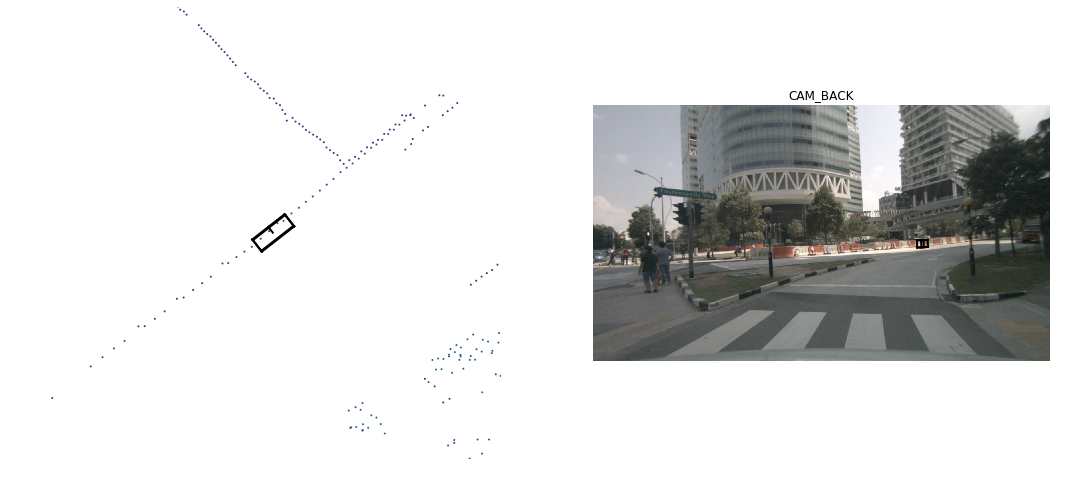

In [44]:
nusc.render_annotation(my_sample['anns'][22])

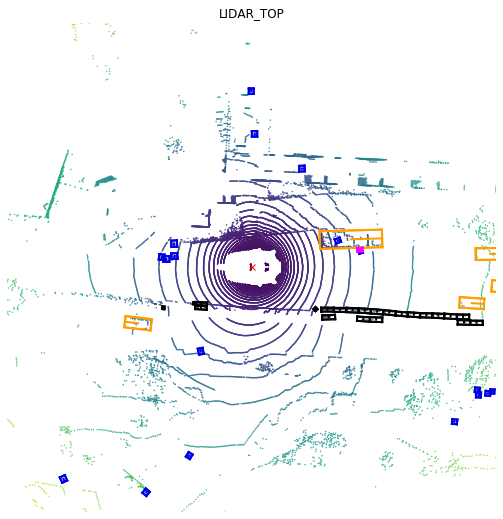

In [27]:
def nuscenes_test(sweeps=5):
    lidar_data = nusc.get('sample_data', my_sample['data']['LIDAR_TOP'])
    #pp.pprint(lidar_data['calibrated_sensor_token'])
    file_path = nuscenes_root+data_name+'/'+lidar_data['filename']
    points = LidarPointCloud.from_file(file_path)
   # pp.pprint(points.points)
#    pc.render_intensity()
    nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=1,
                            underlay_map=False)
nuscenes_test(1)